In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

used matpotlib and seaborn for visualization
and minmax scaler for preprocesssing to normalize energy values into a fixed rage

In [3]:
def load_dataset(file_path):
    df = pd.read_csv(
        file_path,
        sep=';',
        na_values='?',
        low_memory=False
    )
    print("Dataset loaded successfully")
    print(f"Shape: {df.shape}")
    return df


df = load_dataset(
    r"C:\Users\vinay\OneDrive\Desktop\ML project\household_power_consumption.zip"
)


Dataset loaded successfully
Shape: (2075259, 9)


loaded the dataset along with the shape of the dataset 
there are 2075259 rows and 9 columns


In [4]:
def dataset_overview(df):
    print("\n DATASET OVERVIEW ")
    print(df.head())
    print("\n DATA TYPES & NON-NULL COUNTS ")
    print(df.info())
    print("\n STATISTICAL SUMMARY ")
    print(df.describe())


dataset_overview(df)



 DATASET OVERVIEW 
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  

 DATA TYPES & NON-NULL COUNTS 
<class 'pandas.core.frame.DataFrame'>
RangeInde

performed initial exploratory data analysis to understand the struture, datatypes and the properties of the dataset

Date and Time must be converted to DateTime and
some columns contain missing values

In [5]:
def missing_value_report(df):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    report = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent
    })
    print("\n MISSING VALUE REPORT ")
    print(report[report['Missing Values'] > 0])
    return report


missing_report = missing_value_report(df)



 MISSING VALUE REPORT 
                       Missing Values  Percentage (%)
Global_active_power             25979        1.251844
Global_reactive_power           25979        1.251844
Voltage                         25979        1.251844
Global_intensity                25979        1.251844
Sub_metering_1                  25979        1.251844
Sub_metering_2                  25979        1.251844
Sub_metering_3                  25979        1.251844


got to know which columns have missing data and how many values are missing

In [6]:
def create_datetime_index(df):
    df['DateTime'] = pd.to_datetime(
        df['Date'] + ' ' + df['Time'],
        format='%d/%m/%Y %H:%M:%S'
    )
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.set_index('DateTime', inplace=True)
    print("\nDateTime index created successfully")
    return df


df = create_datetime_index(df)



DateTime index created successfully


In [7]:
def convert_to_numeric(df):
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    print("\nAll features converted to numeric format")
    return df


df = convert_to_numeric(df)



All features converted to numeric format


combined separate Date and Time columns into a single DateTime index

all columns are coverted to float


In [8]:
def handle_missing_values(df):
    before = df.isnull().sum().sum()
    df.fillna(method='ffill', inplace=True)
    after = df.isnull().sum().sum()
    
    print(f"\nMissing values before: {before}")
    print(f"Missing values after : {after}")
    return df


df = handle_missing_values(df)



Missing values before: 181853
Missing values after : 0


C:\Users\vinay\AppData\Local\Temp\ipykernel_5252\1897341613.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


since the dataset is a time series data I used forward-fill method to ensure data continuity by handling the missing values

forward fill method means replacing the missing values with the last valid observed value


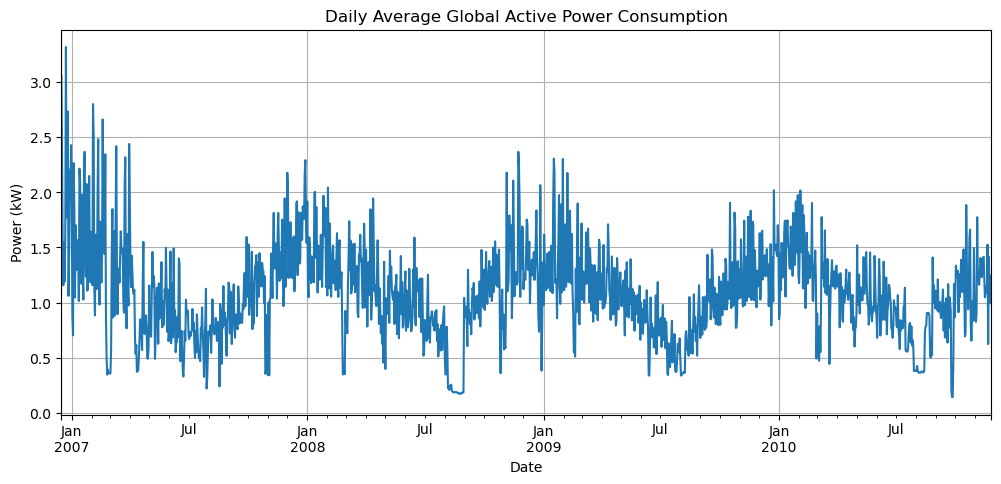

In [9]:
def plot_energy_trend(df):
    plt.figure(figsize=(12,5))
    df['Global_active_power'].resample('D').mean().plot()
    plt.title("Daily Average Global Active Power Consumption")
    plt.xlabel("Date")
    plt.ylabel("Power (kW)")
    plt.grid(True)
    plt.show()


plot_energy_trend(df)


used plotting to show energy consumption trends over time which is useful in training ML models

plotted x-axis as time and y-axis as power

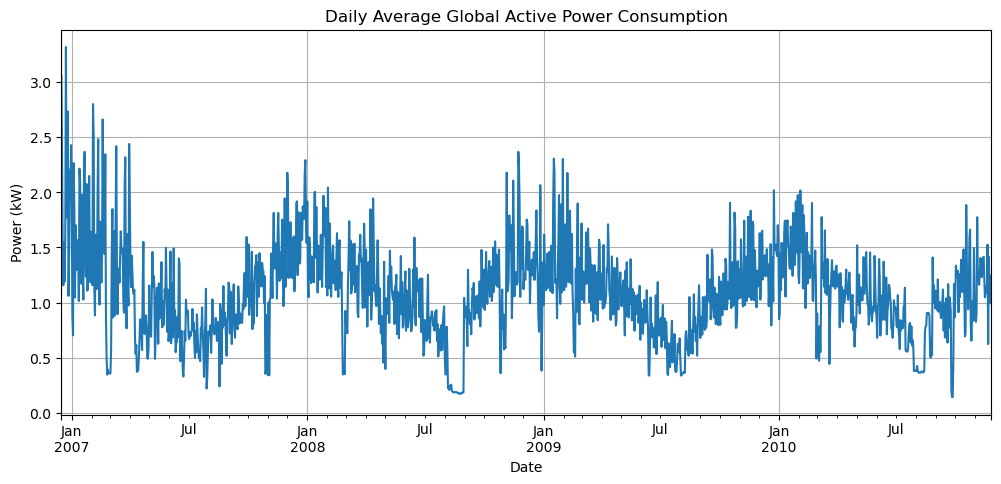

In [10]:
def plot_energy_trend(df):
    plt.figure(figsize=(12,5))
    df['Global_active_power'].resample('D').mean().plot()
    plt.title("Daily Average Global Active Power Consumption")
    plt.xlabel("Date")
    plt.ylabel("Power (kW)")
    plt.grid(True)
    plt.show()


plot_energy_trend(df)


plotted the daily average of global active power to observe energy usage trends

In [11]:
def detect_outliers(df, columns=None):
    
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    
    outliers_summary = pd.DataFrame(columns=['Column', 'Total Outliers', 'Percentage (%)'])
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        total_outliers = outliers.shape[0]
        percent = (total_outliers / df.shape[0]) * 100
        
        outliers_summary = pd.concat([outliers_summary, 
                                      pd.DataFrame({'Column':[col], 
                                                    'Total Outliers':[total_outliers], 
                                                    'Percentage (%)':[percent]})])
    print(outliers_summary)
    
    return outliers_summary


In [12]:
def remove_outliers(df, columns=None):

    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
    
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    print("\nOutliers removed using IQR method")
    print(f"Original shape: {df.shape}, New shape: {df_clean.shape}")
    return df_clean


used inter quartile range to detect and remove outliers

In [13]:
def resample_data(df):
    hourly = df.resample('H').mean()
    daily = df.resample('D').mean()
    
    print("\nResampling completed (Hourly & Daily)")
    return hourly, daily


hourly_df, daily_df = resample_data(df)


C:\Users\vinay\AppData\Local\Temp\ipykernel_5252\4142708552.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df.resample('H').mean()



Resampling completed (Hourly & Daily)


resampled the dataset into hourly and daily averages.

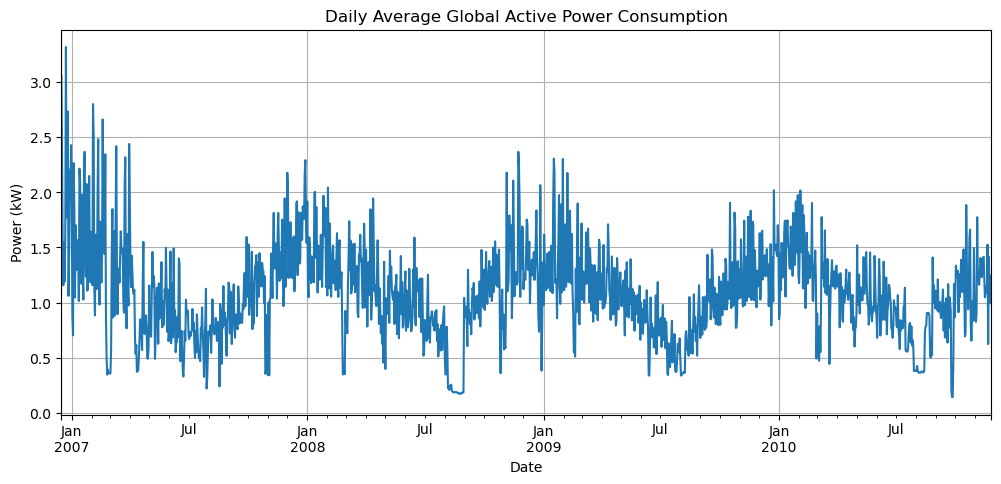

In [19]:
def plot_daily_energy(daily_df):
    plt.figure(figsize=(12,5))
    daily_df['Global_active_power'].plot()
    plt.title("Daily Average Global Active Power Consumption")
    plt.xlabel("Date")
    plt.ylabel("Power (kW)")
    plt.grid(True)
    plt.show()


plot_daily_energy(daily_df)


In [21]:
from sklearn.preprocessing import MinMaxScaler

def normalize_energy(daily_df):
    scaler = MinMaxScaler()
    
    daily_df['Scaled_Global_active_power'] = scaler.fit_transform(
        daily_df[['Global_active_power']]
    )
    
    print("\nEnergy values normalized using Min-Max Scaling")
    return daily_df, scaler


daily_df, scaler = normalize_energy(daily_df)



Energy values normalized using Min-Max Scaling


In [23]:
def split_dataset(data, train_ratio=0.7, val_ratio=0.15):
    train_end = int(len(data) * train_ratio)
    val_end = train_end + int(len(data) * val_ratio)
    
    train = data[:train_end]
    val = data[train_end:val_end]
    test = data[val_end:]
    
    print("\nDataset split completed")
    print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")
    
    return train, val, test


train, val, test = split_dataset(
    daily_df['Scaled_Global_active_power'].values
)



Dataset split completed
Train: 1009, Validation: 216, Test: 217


In [25]:
def generate_preprocessing_report(df, hourly_df, daily_df, missing_report):

    print("\nPREPROCESSING REPORT\n")

    print("1. Dataset Overview:")
    print(f"- Total rows: {df.shape[0]}")
    print(f"- Total columns: {df.shape[1]}")
    print("- Columns and types:")
    print(df.dtypes)
    print("\n- First 5 rows:")
    print(df.head())

    print("\n2. Missing Values Report:")
    total_missing = missing_report['Missing Values'].sum()
    print(f"- Total missing values before handling: {total_missing}")
    if total_missing > 0:
        print("- Missing values per column:")
        print(missing_report[missing_report['Missing Values'] > 0])
    else:
        print("- No missing values detected.")
    
    print("\n3. DateTime Conversion:")
    print("- Date and Time columns were combined into a single 'DateTime' index.")
  
    print("\n4. Numeric Conversion:")
    print("- All columns converted to numeric data types.")
    print("- Non-numeric or invalid entries replaced with NaN.")
    

    print("\n5. Missing Value Handling:")
    print("- Missing values were handled using forward-fill imputation.")

    
   
    print("\n6. Resampling:")
    print(f"- Original dataset shape: {df.shape}")
    print(f"- Hourly resampled dataset shape: {hourly_df.shape}")
    print(f"- Daily resampled dataset shape: {daily_df.shape}")
    
    
    
    print("\n7. Statistical Summary (after preprocessing):")
    print(daily_df.describe())
    

generate_preprocessing_report(df, hourly_df, daily_df, missing_report)



PREPROCESSING REPORT

1. Dataset Overview:
- Total rows: 2075259
- Total columns: 7
- Columns and types:
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

- First 5 rows:
                     Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                  

In [7]:
df.to_csv("cleaned_energy_data.csv")
